# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd 

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Приведем название всех столбцов к змеиному регистру

In [3]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest',
                           'parks_around3000':'parks_around_3000',
                           'ponds_around3000':'ponds_around_3000'})

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'city_centers_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around_3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around_3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]]

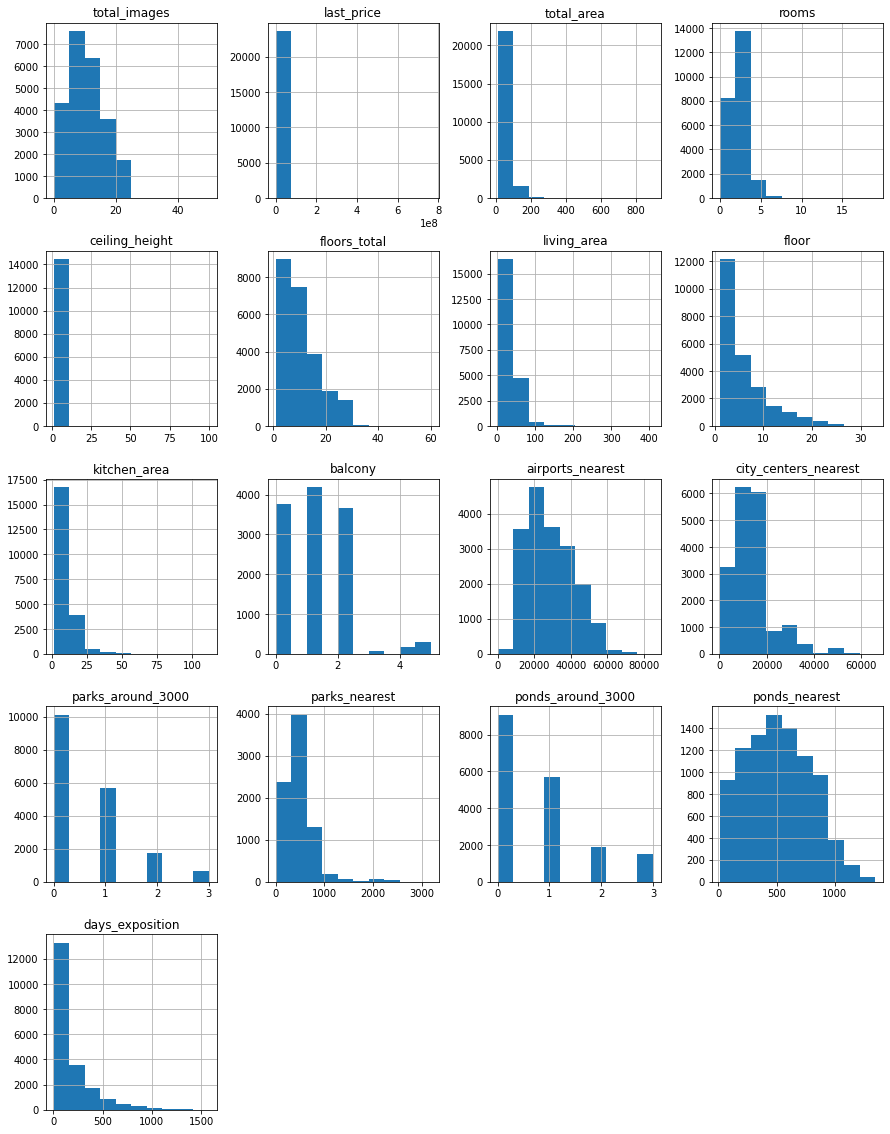

In [4]:
data.hist(figsize=(15, 20))

### Предобработка данных

Посчитаем количество пропусков в каждом столбце

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Если продавец не указал количество балконов, то, предположительно, их нет. Заполним пропущенные значения в столбце 'balcony' на 0

In [6]:
data['balcony'] = data['balcony'].fillna(0)

Проверим пропуски в стобце "kitchen_area". Можно проверить являются ли студиями квартиры с пропущенными значениями площадью кухни

In [7]:
data[data['kitchen_area'].isna()]['studio'].value_counts()

False    2129
True      149
Name: studio, dtype: int64

Посчитав значения, убедились, что большая часть таких квартир не являются студиями. Соответственно, заполнять пропуски в столбце площади кухни нулями будет неверно. Можно было бы получить площадь кухни в разнице между общей  (total_area) и жилой площадью (living_area), но подсчеты будут не корректны в связи с тем что помимо кухни не жилой площадью в квартире могут являться и другие помещения. Оставим столбец как есть

Можно предположить что пропуски в столбцах 'parks_around_3000' и 'ponds_around_3000' говорит о том что в районе 3 км от квартиры нет парков и водоёмов. Заполним пропуски в этих столбцах на 0

In [8]:
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)

Заполним пропуски в столбце 'locality_name' на 'не указан' 

In [9]:
data['locality_name'] = data['locality_name'].fillna('не указан')

Очень много пропусков в столбце 'is_apartment', но этот показатель, на мой взгляд, ни на что не влияет в рамках данного исследования. Эти пропуски можно игнорировать

Изменим тип данных столбца 'first_day_exposition' на datetime чтобы было проще с ними работать в дальнейшем

In [10]:
data['first_day_exposition'] = pd.to_datetime(arg= data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим строки датафрейма на очевидные дубликаты

In [11]:
data.duplicated().sum()

0

Таких дубликатов нет. Проверим на неявные дубликаты столбец 'locality_name'

In [12]:
print(len(data['locality_name'].unique()))
print()
print(data['locality_name'].unique())

365

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новы

Столбец содержит в себе 365 уникальных значений, но просмотрев эти значения можно попробовать избавиться от неявных дубликатов заменив некоторую часть строки приводя к однотипному виду.

Создадим новый столбец **'locality_name_no_duplicates'** для сохранения результата и заменим все 'ё' на 'е'. Затем заменим части строк содержащие 'поселок городского типа' и 'городской поселок' на 'поселок'

In [13]:
data['locality_name_no_duplicates'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name_no_duplicates'] = data['locality_name_no_duplicates'].str.replace('поселок городского типа', 'поселок')
data['locality_name_no_duplicates'] = data['locality_name_no_duplicates'].str.replace('городской поселок', 'поселок')

In [14]:
print(len(data['locality_name_no_duplicates'].unique()))

323


В результате получилось 323 уникальных значения. Мы избавились от 42 неявных дубликата. (пробовал перевести весь столбец в нижний регистр, но уникальных значений меньше не стало. удалил эту часть кода)

Проверим аномальные значения в столбце 'ceiling_height'. Посмотрим первые 20 отсортированных уникальных значений и последние 20

In [15]:
print(sorted(data['ceiling_height'].unique())[:20])
print(sorted(data['ceiling_height'].unique())[-20:])

[1.0, 2.0, 2.3, 2.4, 2.45, 2.46, 2.48, 2.53, 2.59, 2.62, 2.63, 2.7, nan, 1.2, 1.75, 2.2, 2.25, 2.34, 2.47, 2.49]
[5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 10.3, 14.0, 20.0, 22.6, 24.0, 25.0, 26.0, 27.0, 27.5, 32.0, 100.0]


Мы сталкиваемся с аномалиями. Высота потолков по закону не может быть меньше 2.5 метра. Можно предположить что и 10 метров быть не могут тем более 100. Посчитаем сколько всего строк во всем датафрейме входят в категорию 'меньше 2.4 метров' и сколько в 'больше 10 метров'

In [16]:
(data['ceiling_height'] < 2.4).sum()

21

In [17]:
(data['ceiling_height'] > 10).sum()

25

Этих значений очень мало. Можно создать функцию в которой попробуем обработать все значения в столбце 'ceiling_height' и либо отбросим их либо приведем к нормальному виду

In [18]:
def ceiling_height_anomaly(height):
    if height < 2.4:
        return None
    elif 2.4 <= height < 10:
        return height
    elif 24 <= height < 100:
        return height/10
    elif height == 100:
        return None

In [19]:
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height_anomaly)

Посчитаем количество NaN после нашей функции

In [20]:
data['ceiling_height'].isna().sum()

9221

Изначально пропусков в этом столбце было 9195. Прибавилось всего 26 пропусков зато мы избавились от аномальных значений

In [21]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()

0

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   total_images                 23699 non-null  int64         
 1   last_price                   23699 non-null  float64       
 2   total_area                   23699 non-null  float64       
 3   first_day_exposition         23699 non-null  datetime64[ns]
 4   rooms                        23699 non-null  int64         
 5   ceiling_height               23699 non-null  float64       
 6   floors_total                 23613 non-null  float64       
 7   living_area                  21796 non-null  float64       
 8   floor                        23699 non-null  int64         
 9   is_apartment                 2775 non-null   object        
 10  studio                       23699 non-null  bool          
 11  open_plan                    23699 non-nu

Проверим столбец **'last_price'** на аномальные значения

In [23]:
print(data['last_price'].min())

12190.0


Минимальное значение в этом столбце = 12190.0. Выведем на экран первые 5 значения выше минимального отсортированные по возростанию

In [24]:
data[data['last_price'] >= 12190.0].sort_values(by='last_price').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_no_duplicates
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,...,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,Санкт-Петербург
17456,7,430000.0,30.4,2019-04-22,1,2.65,2.0,16.0,1,NaN,...,0.0,Сланцы,NaN,NaN,0.0,NaN,0.0,NaN,NaN,Сланцы
14911,5,430000.0,54.0,2018-06-26,2,2.65,3.0,NaN,3,NaN,...,0.0,посёлок станции Свирь,NaN,NaN,0.0,NaN,0.0,NaN,44.0,поселок станции Свирь
16274,18,440000.0,40.0,2018-07-10,1,2.65,5.0,NaN,1,NaN,...,0.0,деревня Старополье,NaN,NaN,0.0,NaN,0.0,NaN,45.0,деревня Старополье
17676,0,450000.0,36.5,2018-02-01,1,2.65,5.0,17.3,4,NaN,...,1.0,деревня Ям-Тесово,NaN,NaN,0.0,NaN,0.0,NaN,120.0,деревня Ям-Тесово


Квартира в Санкт-Петербурге с общей площадью 109 не может стоить 12190 рублей. Дальше значения укладываются в логические нормы. От строчки с минимальным значением можно избавиться

In [25]:
data = data[data['last_price'] > 12190.0]

In [26]:
data['living_area'] = data['living_area'].fillna(data['total_area'] / (data['total_area'].mean() / data['living_area'].mean()))

data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] / (data['total_area'].mean() / data['kitchen_area'].mean()))


### Посчитайте и добавьте в таблицу новые столбцы

Для удобства представления данных на графике можно создать новый столбец который будет показывать конечную стоимость недвижимости в миллионах

In [27]:
data['last_price_mln'] = data['last_price'] / 1000000

Для подсчета стоимости одного квадратного метра поделим значения столбца конечной стоимости на общую площадь и сохраним полученные значения в новый столбец

In [28]:
data['square_meter_price'] = data['last_price'] / data['total_area']

Получим день недели из столбца 'first_day_exposition' где 0 - понедельник, а 6 - воскресенье и сохраним значения в новый столбец

In [29]:
data['exposition_week_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

Точно так же получим месяц и год

In [30]:
data['exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['exposition_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

Чтобы получить расстояние до центра в КМ из М поделим значения из столбца 'cityCenters_nearest' на 1000 и округлим к ближайшему целому значению

In [31]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

Создадим функцию которая будет принимать в себя строку из датафрейма и возвращать нам этаж на которой рассположено жилье (первый, последний, другой)

In [32]:
def floor_is(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

Применим функцию и сохраним полученные значения в новом столбце 

In [33]:
data['floor_is'] = data.apply(floor_is, axis=1)

Взглянем на первые 15 строк из добавленных столбцов

In [34]:
data[['square_meter_price', 
      'exposition_week_day', 
      'exposition_month', 
      'exposition_year', 
      'city_centers_nearest_km', 
      'floor_is',
     'last_price_mln']].head(15)

,square_meter_price,exposition_week_day,exposition_month,exposition_year,city_centers_nearest_km,floor_is,last_price_mln
0,120370.370370,3,3,2019,16.0,другой,13.000
1,82920.792079,1,12,2018,19.0,первый,3.350
2,92785.714286,3,8,2015,14.0,другой,5.196
3,408176.100629,4,7,2015,7.0,другой,64.900
4,100000.000000,1,6,2018,8.0,другой,10.000
5,95065.789474,0,9,2018,NaN,другой,2.890
6,99195.710456,3,11,2017,19.0,другой,3.700
7,110544.692737,3,4,2019,12.0,другой,7.915
8,87454.764777,2,5,2018,NaN,другой,2.900
9,88524.590164,6,2,2017,15.0,другой,5.400


### Исследовательский анализ данных

<AxesSubplot:>

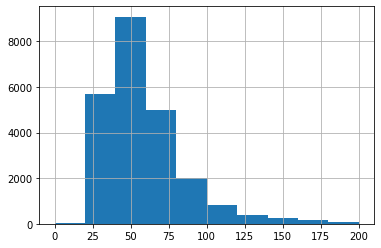

In [35]:
data['total_area'].hist(range=(0, 200))

Основная масса квартир площадью от 25 до 100 квадратных метров

<AxesSubplot:>

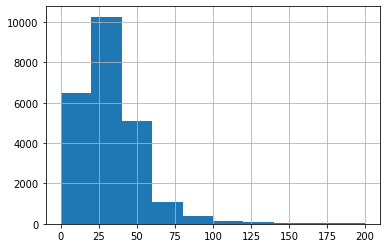

In [36]:
data['living_area'].hist(range=(0, 200))

Гистограмма по жилой зоне идентична общей площади квартиры и, что логично, смещена влево

<AxesSubplot:>

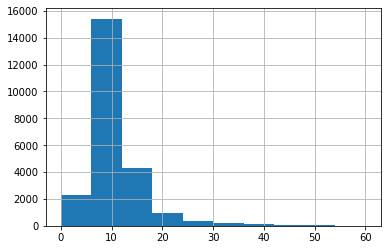

In [37]:
data['kitchen_area'].hist(range=(0,60))

<AxesSubplot:>

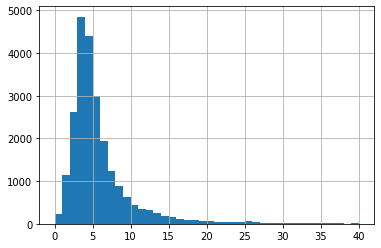

In [38]:
data['last_price_mln'].hist(bins=40,range=(0, 40))

<AxesSubplot:>

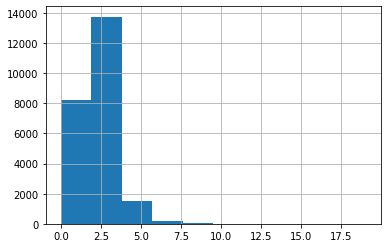

In [39]:
data['rooms'].hist()

<AxesSubplot:>

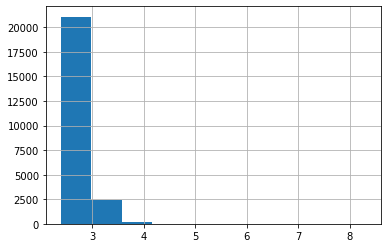

In [40]:
data['ceiling_height'].hist()

<AxesSubplot:>

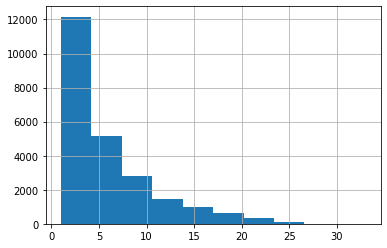

In [41]:
data['floor'].hist()

<AxesSubplot:>

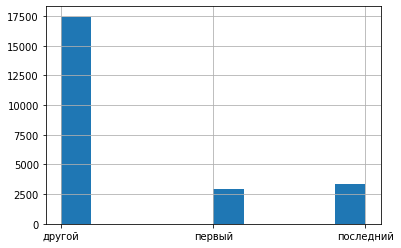

In [42]:
data['floor_is'].hist()

<AxesSubplot:>

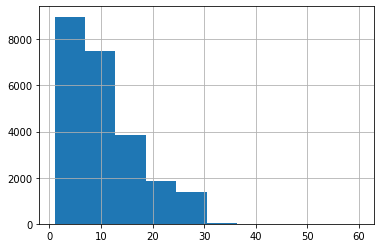

In [43]:
data['floors_total'].hist()

<AxesSubplot:>

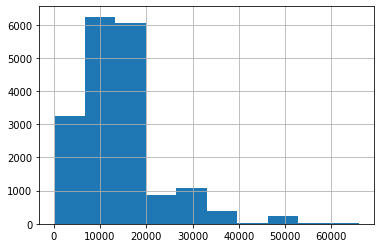

In [44]:
data['city_centers_nearest'].hist()

<AxesSubplot:>

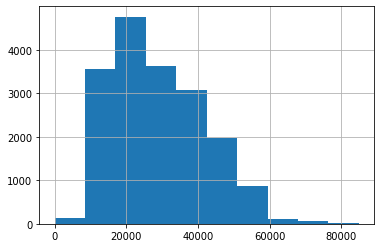

In [45]:
data['airports_nearest'].hist()

<AxesSubplot:>

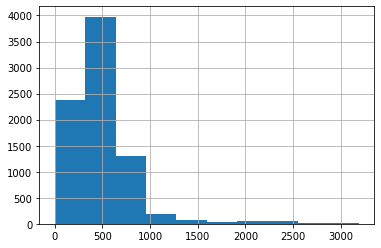

In [46]:
data['parks_nearest'].hist()

<AxesSubplot:>

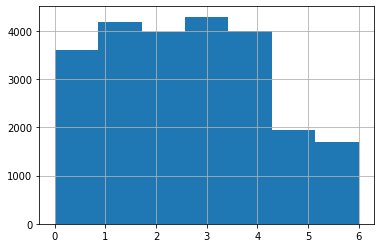

In [47]:
data['exposition_week_day'].hist(bins=7)

<AxesSubplot:>

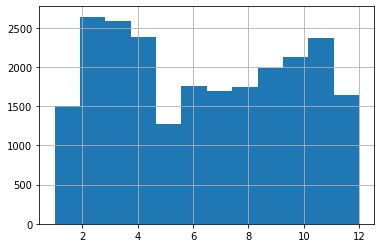

In [48]:
data['exposition_month'].hist(bins=12)

<AxesSubplot:>

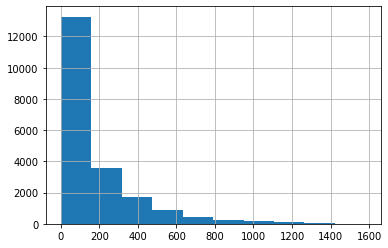

In [49]:
data['days_exposition'].hist()

In [50]:
data['days_exposition'].describe()

count    20517.000000
mean       180.897061
std        219.730028
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Средняя скорость продажи квартры - 180 дней, а медианная - 95

Быстрыми можно считать продажи которые занимают до 45 дней а долгими от 232 что соответсвует 25 и 75 % от статистики

Для выяснения зависимости цены от площади квартиры построим точечный график и проверим корреляцию

In [51]:
data['total_area'].corr(data['last_price'])

0.6537402377092495

<AxesSubplot:xlabel='total_area', ylabel='last_price_mln'>

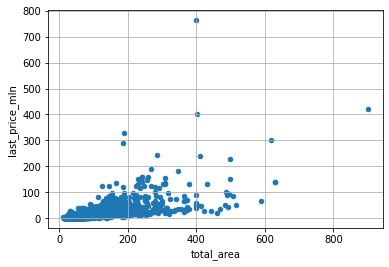

In [52]:
data.plot(x='total_area', y='last_price_mln', kind='scatter', grid=True)

Корреляция состоявляет 0.65 и по графику видно что, чем больше площадь тем выше стоимость, что логично (еще на графике видны аномальные выбросы по стоимости в разы превышающие средние показатели, но их не много)

Проделаем такие же действия со столбцами **'living_area', 'kitchen_area', 'rooms'**

Корреляция: 0.5857886604770651


<AxesSubplot:xlabel='living_area', ylabel='last_price_mln'>

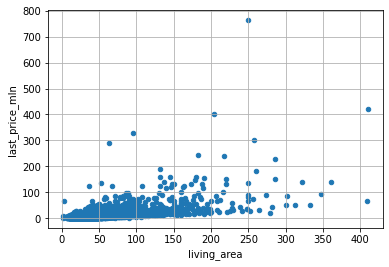

In [53]:
print('Корреляция:', data['last_price'].corr(data['living_area']))

data.plot(x='living_area', y='last_price_mln', kind='scatter', grid=True)

Корреляция: 0.5145476976769694


<AxesSubplot:xlabel='kitchen_area', ylabel='last_price_mln'>

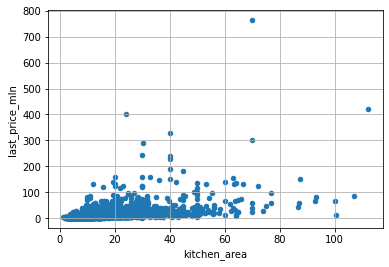

In [54]:
print('Корреляция:', data['last_price'].corr(data['kitchen_area']))

data.plot(x='kitchen_area', y='last_price_mln', kind='scatter', grid=True)

Корреляция: 0.36334398266009404


<AxesSubplot:xlabel='rooms', ylabel='last_price_mln'>

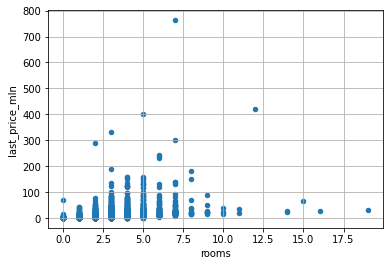

In [55]:
print('Корреляция:', data['last_price'].corr(data['rooms']))

data.plot(x='rooms', y='last_price_mln', kind='scatter', grid=True)

С **'living_area'** и **'kitchen_area'** ситуация схожая, а вот с **'rooms'**, от 0 до 5 комнат стоимость растет, а с 5 и дальше идет на спад (так же видны точки с аномальной высокой стоимостью)

Сгруппируем данные по этажу (первый, последний, другой) и по медианому значению стоимости квартиры этой группы. Построим barplot на основании этих данных

Корреляция: 0.026683449634762275


<AxesSubplot:xlabel='floor_is'>

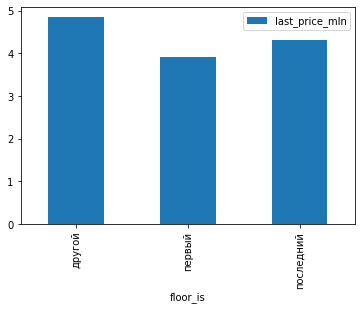

In [56]:
print('Корреляция:', data['last_price'].corr(data['floor']))

data.pivot_table(index='floor_is', values='last_price_mln', aggfunc='median').plot(kind='bar')

<AxesSubplot:xlabel='exposition_week_day'>

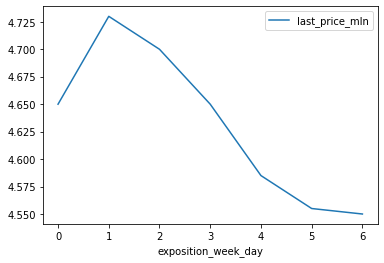

In [57]:
data.pivot_table(index='exposition_week_day', values='last_price_mln', aggfunc='median').plot()

Медианная стоимость жилья во вторник выше чем в другие и самый низкий показатель по воскресеньям

<AxesSubplot:xlabel='exposition_month'>

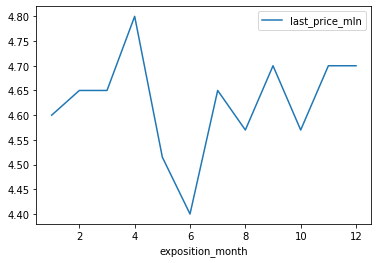

In [58]:
data.pivot_table(index='exposition_month', values='last_price_mln', aggfunc='median').plot()

Дешевле квартиры выставленные в июне 

<AxesSubplot:xlabel='exposition_year'>

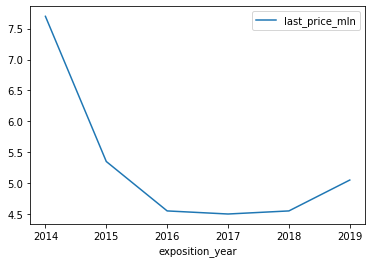

In [59]:
data.pivot_table(index='exposition_year', values='last_price_mln', aggfunc='median').plot()

Медианная стоимость квартир выше в 2014 году и потом наблюдается резкое падение до 2018 года и небольшая коррекция в 2019-ом

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Для этого сгруппируем данные по населенным пунктам и по стоимости одного квадратного метра жилья применив к ним метод count (для получения количества объявлений) и mean (для получения средней стоимости одного квадратного метра)

Отсортируем по count чтобы получить в начале пункты с наибольшим количеством объявлений и возьмем только первые 10 строк. Сохраним все это во временную переменную temp

In [60]:

    temp = (data
    .pivot_table(index='locality_name_no_duplicates', values='square_meter_price', aggfunc=['count', 'mean'])
    .sort_values(by=('count', 'square_meter_price'), ascending=False)
    .head(10)
)
temp

,count,mean
,square_meter_price,square_meter_price
locality_name_no_duplicates,,
Санкт-Петербург,15720,114856.307596
поселок Мурино,556,85681.762601
поселок Шушары,440,78677.364217
Всеволожск,398,68654.473986
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763


Выведем из списка максимальное значение по ('mean', 'square_meter_price')

In [61]:
display(temp[temp[('mean', 'square_meter_price')] == temp[('mean', 'square_meter_price')].max()])

,count,mean
,square_meter_price,square_meter_price
locality_name_no_duplicates,,
Санкт-Петербург,15720,114856.307596


И минимальное значение

In [62]:
display(temp[temp[('mean', 'square_meter_price')] == temp[('mean', 'square_meter_price')].min()])

,count,mean
,square_meter_price,square_meter_price
locality_name_no_duplicates,,
Выборг,237,58141.909153


**Вывод:** Из 10 населенных пунктов с наибольшим количеством объявлений по продаже Санкт-Петербург занимает первое место и по количеству объявлений и по средней стоимости одного квадратного метра жилья, а Выборг последнее

Выберем из датафрейма только строки с Санкт-Петербургом

In [63]:
data_spb = data[data['locality_name_no_duplicates'] == 'Санкт-Петербург']

Создадим сводную таблицу по расстоянию от центра и от средней стоимости жилья

In [64]:
data_spb.pivot_table(index='city_centers_nearest_km', values='last_price_mln')

,last_price_mln
city_centers_nearest_km,
0.0,31.449116
1.0,21.206721
2.0,17.788320
3.0,11.126581
4.0,13.304280
5.0,14.499121
6.0,15.338418
7.0,14.775153
8.0,9.957717


Выведем barplot для этой таблицы для наглядности 

<AxesSubplot:xlabel='city_centers_nearest_km'>

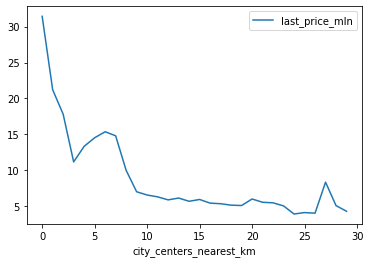

In [65]:
data_spb.pivot_table(index='city_centers_nearest_km', values='last_price_mln').plot()

**Вывод:** Чем дальше квартира расположена от центра города, тем она дешевле (в среднем)

### Общий вывод

Была проведена предобработка данных, а так же добавлены все необходимые для работы новые столбцы.



Во время проведения исследовательского анализа данных мы проанализировали скорость продажи квартир. График показывал что большая часть квартир продавались меньше чем за 200 дней.

Проверили корреляцию стоимости от разных факторов и выяснили что стоимость взаимосвязана с площадью квартиры (что логично). Так же выяснилось что медианая стоимость квартир на первом и последнем этахаж ниже чем на других.

Еще можно сказать что квартиры в июне стояли дешевле чем в другие месяца, а золотым годом для продажи недвижимости стал 2014 (стоимость квартир в 2014 году была высокая)

Так же в ходе исследования было выявлено что больше всего объявлений было в Санкт-Петербурге и там же самая высокая стоимость за 1 квадратный метр.

И последнее. Изучая данные по Санкт-Петербургу было обнаружено что стоимость квартир сильно зависит от того насколько далеко она рассположена от центра. Разница в стоимости ощутима на первых 9-10 километро, а дальше снижение становится более плавным. В среднем стоимость одного километра составляет почти 1 миллион.